In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re

HEADER_PATTERN = 'BatteryMgr:DataCollectionService: onStartCommand: rawFields => '
DATA_PATTERN = 'BatteryMgr:DataCollectionService: stats => '

def reset_timestamp(df):
    df['Timestamp'] = df['Timestamp'] - df['Timestamp'][0]
    df['Timestamp'] = df['Timestamp'] / 1000
    return df

def find_clumsy_directories(root='.'):
    res = []
    for dirpath, dirnames, filenames in os.walk(root):
        for dirname in dirnames:
            if 'clumsy' in dirname.lower() or 'validation' in dirname.lower():
                res.append(os.path.join(dirpath, dirname))
    return res

def calculate_power(df):
    df['power'] = (abs(df['BATTERY_PROPERTY_CURRENT_NOW']) / 1000 / 1000) * (df['EXTRA_VOLTAGE'] / 1000)
    return df

def trapezoid_method(df):
    return np.trapz(df['power'].values, df['Timestamp'].values), df['Timestamp'].values[-1]


def get_column_names(file):
    pattern = re.compile(HEADER_PATTERN)
    cols = []
    for line in open(file, encoding='utf-16'):
        if pattern.search(line):
            cols = line.split(HEADER_PATTERN)[1].split(',')
            cols = [col.strip() for col in cols]
            break
    return cols

def get_data(file):
    pattern = re.compile(DATA_PATTERN)
    data = []
    for line in open(file, encoding='utf-16'):
        if pattern.search(line):
            data.append(line.split(DATA_PATTERN)[1].strip('\n').split(','))

    return data

def generate_csv(data_path):
    cols = get_column_names(data_path)
    data = get_data(data_path)
    df = pd.DataFrame(data, columns=cols)
    df['Timestamp'] = np.int64(df['Timestamp'])
    df['BATTERY_PROPERTY_CURRENT_NOW'] = np.int64(df['BATTERY_PROPERTY_CURRENT_NOW'])
    df['EXTRA_VOLTAGE'] = np.int64(df['EXTRA_VOLTAGE'])
    df = reset_timestamp(df)
    df = calculate_power(df)
    df.to_csv(f'.\\{data_path.strip(".log")}.csv', index=False)
    return df

def create_dataframe(file_path):
    df = pd.DataFrame()
    if len(file_path.split('\\')[1].split('-')) == 3:
        altered_bandwidth = file_path.split('\\')[1].split('-')[1] == 'bandwidth'
        altered_dropchance = file_path.split('\\')[1].split('-')[1] == 'dropchance'
        bandwidth = int(file_path.split('\\')[1].split('-')[2][:-4]) if file_path.split('\\')[1].split('-')[1] == 'bandwidth' else 999999
        dropchance = float(file_path.split('\\')[1].split('-')[2]) if file_path.split('\\')[1].split('-')[1] == 'dropchance' else 0
    else:
        altered_bandwidth = True
        altered_dropchance = True
        bandwidth = 999999
        dropchance = 0
    device = file_path.split('\\')[2]
    app = file_path.split('\\')[3].strip('-W')
    app_details = file_path.split('\\')[4]
    is_record = 'record' in file_path.split('\\')[5]
    is_wireless = '-W' in file_path.split('\\')[3]
    repetition = file_path.split('\\')[5].strip('record') if 'record' in file_path.split('\\')[5] else file_path.split('\\')[5].strip('replay')
    
#     print(df)
    return [altered_bandwidth, altered_dropchance, bandwidth, dropchance, device, app, app_details, is_record, is_wireless, repetition]


clumsy_dirs = find_clumsy_directories()

df_aggregated = []  # List to store dictionaries for each row

for clumsy in clumsy_dirs:
    for root, dirs, files in os.walk(clumsy, topdown=False):
        for name in files:
            if name == 'battery_manager.log':
                if os.path.join(root, name) == '.\\clumsy-dropchance-0.05\\Quest-Pro\\BeatSaber\\PopStars-Medium\\replay1.2\\battery_manager.log':
                    continue
                try:
                    print(os.path.join(root, name))
                    energy, length = trapezoid_method(generate_csv(os.path.join(root, name)))
                    row_data = create_dataframe(os.path.join(root, name)) + [energy, length, float(energy / length)]
                    # Append a dictionary for each row
                    df_aggregated.append(dict(zip(['altered_bandwidth', 'altered_dropchance', 'bandwidth', 'dropchance', 'device', 'app', 'app_details', 'is_record', 'is_wireless', 'repetition', 'energy(J)', 'length(s)', 'Energy per Second (J/s)'], row_data)))
                except:
                    print(f'{os.path.join(root, name)} not functional')

# Create DataFrame from the list of dictionaries
df = pd.DataFrame(df_aggregated)
df

.\clumsy-bandwidth-100Mbps\Quest-2\BeatSaber\PopStars-Medium\record1\battery_manager.log
.\clumsy-bandwidth-100Mbps\Quest-2\BeatSaber\PopStars-Medium\replay1.0\battery_manager.log
.\clumsy-bandwidth-100Mbps\Quest-2\BeatSaber\PopStars-Medium\replay1.1\battery_manager.log
.\clumsy-bandwidth-100Mbps\Quest-2\BeatSaber\PopStars-Medium\replay1.2\battery_manager.log
.\clumsy-bandwidth-100Mbps\Quest-Pro\BeatSaber\PopStars-Medium\record1\battery_manager.log
.\clumsy-bandwidth-100Mbps\Quest-Pro\BeatSaber\PopStars-Medium\replay1.0\battery_manager.log
.\clumsy-bandwidth-100Mbps\Quest-Pro\BeatSaber\PopStars-Medium\replay1.1\battery_manager.log
.\clumsy-bandwidth-100Mbps\Quest-Pro\BeatSaber\PopStars-Medium\replay1.2\battery_manager.log
.\clumsy-bandwidth-30Mbps\Quest-2\BeatSaber\PopStars-Medium\record1\battery_manager.log
.\clumsy-bandwidth-30Mbps\Quest-2\BeatSaber\PopStars-Medium\replay1.0\battery_manager.log
.\clumsy-bandwidth-30Mbps\Quest-2\BeatSaber\PopStars-Medium\replay1.1\battery_manager.log


.\overhead-validation\Quest-Pro\BeatSaber\PopStars-Medium\replay2.1\battery_manager.log
.\overhead-validation\Quest-Pro\BeatSaber\PopStars-Medium\replay2.2\battery_manager.log
.\overhead-validation\Quest-Pro\BeatSaber\PopStars-Medium\replay2.3\battery_manager.log
.\overhead-validation\Quest-Pro\BeatSaber\PopStars-Medium\replay2.4\battery_manager.log
.\overhead-validation\Quest-Pro\BeatSaber\PopStars-Medium\replay2.5\battery_manager.log
.\overhead-validation\Quest-Pro\BeatSaber\PopStars-Medium\replay2.6\battery_manager.log
.\overhead-validation\Quest-Pro\BeatSaber\PopStars-Medium\replay2.7\battery_manager.log
.\overhead-validation\Quest-Pro\BeatSaber\PopStars-Medium\replay2.8\battery_manager.log
.\overhead-validation\Quest-Pro\BeatSaber\PopStars-Medium\replay2.9\battery_manager.log


,altered_bandwidth,altered_dropchance,bandwidth,dropchance,device,app,app_details,is_record,is_wireless,repetition,energy(J),length(s),Energy per Second (J/s)
0,True,False,100,0.000,Quest-2,BeatSaber,PopStars-Medium,True,False,1,1617.171011,257.057,6.291099
1,True,False,100,0.000,Quest-2,BeatSaber,PopStars-Medium,False,False,1.0,1581.767128,265.926,5.948148
2,True,False,100,0.000,Quest-2,BeatSaber,PopStars-Medium,False,False,1.1,1574.781731,265.785,5.925021
3,True,False,100,0.000,Quest-2,BeatSaber,PopStars-Medium,False,False,1.2,1569.581838,264.700,5.929663
4,True,False,100,0.000,Quest-Pro,BeatSaber,PopStars-Medium,True,False,1,2132.318163,283.780,7.513983
5,True,False,100,0.000,Quest-Pro,BeatSaber,PopStars-Medium,False,False,1.0,1805.029892,266.663,6.768955
6,True,False,100,0.000,Quest-Pro,BeatSaber,PopStars-Medium,False,False,1.1,1776.537834,263.650,6.738243
7,True,False,100,0.000,Quest-Pro,BeatSaber,PopStars-Medium,False,False,1.2,1799.388940,265.653,6.773456
8,True,False,30,0.000,Quest-2,BeatSaber,PopStars-Medium,True,False,1,1617.171011,257.057,6.291099
9,True,False,30,0.000,Quest-2,BeatSaber,PopStars-Medium,False,False,1.0,1620.174799,280.330,5.779527


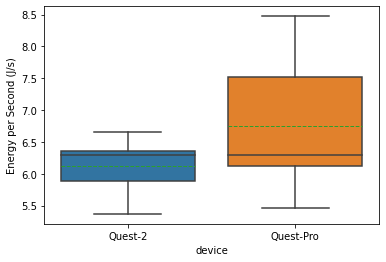

In [27]:
# print(df.empty())
# pd.set_option('Energy per Second (J/s).max_rows', None)

# Print the entire 'device' column
# print(df['Energy per Second (J/s)'])
# print(df.dropna())
# df['device'] = df['device'].astype(str)
sns.boxplot(data=df, x='device', y='Energy per Second (J/s)', showmeans=True, meanline=True)
plt.show()

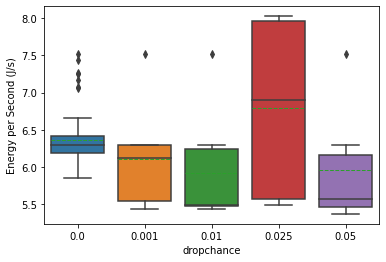

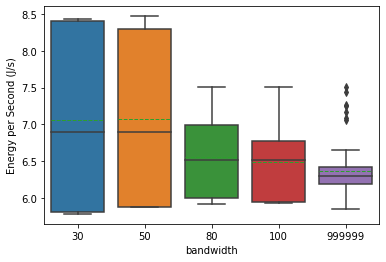

In [30]:
sns.boxplot(data=df[(df.altered_dropchance == True)], x='dropchance', y='Energy per Second (J/s)', showmeans=True, meanline=True)
plt.show()

sns.boxplot(data=df[(df.altered_bandwidth == True)], x='bandwidth', y='Energy per Second (J/s)', showmeans=True, meanline=True)
plt.show()